<a href="https://colab.research.google.com/github/veyselalevcan/Federated-Learning-and-Generative-AI/blob/main/SWaT_Attack_Analysis_with_Federated_Learning_and_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SWaT Attack Analysis with Federated Learning and GANs
This project analyzes cyber attacks on the Secure Water Treatment (SWaT) system using federated learning and generative adversarial networks (GANs).


##Table of Contents
1- Data Loading and Preprocessing

2- Attack Analysis Functions

3- GAN Implementation

4- Federated Learning Implementation

5- Evaluation Pipeline

##1. Data Loading and Preprocessing


* The data loading function handles the SWaT dataset format with proper timestamp parsing

* Attack windows are defined in UTC timezone to ensure consistency

* Each attack is extracted based on its specific time window and relevant columns

* Data is saved to CSV files for further analysis

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

# ==============================================
# STAGE 1: DATA LOADING FROM PRE-EXTRACTED CSVs
# ==============================================

def load_attack_data():
    """Load pre-extracted attack CSV files"""
    attack_files = {
        'Attack1': 'Attack1_FIT401.csv',
        'Attack2': 'Attack2_LIT301.csv',
        'Attack3': 'Attack3_P601.csv',
        'Attack4': 'Attack4_Multi.csv',
        'Attack5': 'Attack5_MV501.csv',
        'Attack6': 'Attack6_P301.csv'
    }

    attacks = {}
    for name, file in attack_files.items():
        try:
            df = pd.read_csv(file, parse_dates=['Timestamp'])
            # Convert numeric columns (European format)
            for col in df.columns:
                if df[col].dtype == 'object':
                    try:
                        df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='ignore')
                    except:
                        pass
            attacks[name] = df
            print(f"✅ {name} loaded with {len(df)} rows")
        except Exception as e:
            print(f"❌ Error loading {name}: {str(e)}")
            attacks[name] = pd.DataFrame()

    return attacks

##2. Attack Analysis Functions



* Each attack is analyzed by visualizing the time series of key metrics

* Handles European decimal format (comma to dot conversion)

* Provides basic statistics for each attack

* Plots are generated with proper timestamps and labels



In [ ]:
# ==============================================
# STAGE 2: ATTACK ANALYSIS AND VISUALIZATION
# ==============================================

def analyze_attack(attack_name, attack_data):
    """Analyze and visualize attack patterns"""
    if attack_data.empty:
        print(f"No data for {attack_name}")
        return

    # Convert status columns to numeric
    for col in attack_data.columns:
        if 'Status' in col:
            attack_data[col] = pd.factorize(attack_data[col])[0]

    # Plot numeric features
    plt.figure(figsize=(12, 6))
    numeric_cols = attack_data.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if col != 'Timestamp':
            plt.plot(attack_data['Timestamp'], attack_data[col], label=col)

    plt.title(f'{attack_name} Attack Pattern')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Show statistics
    print(f"\n{attack_name} Statistics:")
    print(attack_data[numeric_cols].describe())

##3. GAN Implementation

* Implements Wasserstein GAN with Gradient Penalty (WGAN-GP) for stable training

* Generator creates synthetic attack data from random noise

* Discriminator tries to distinguish real from synthetic data

* Gradient penalty helps prevent mode collapse and training instability

* Training loop alternates between generator and discriminator updates

In [ ]:
# ==============================================
# STAGE 3: GAN IMPLEMENTATION
# ==============================================

def build_gan(input_dim, latent_dim=100):
    """Build Wasserstein GAN with Gradient Penalty"""
    # Generator
    generator = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim, dtype='float32'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(input_dim, activation='tanh')
    ])

    # Discriminator
    discriminator = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim, dtype='float32'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return generator, discriminator

def train_gan(generator, discriminator, real_data, latent_dim=100, epochs=500, batch_size=32): # Added latent_dim as an argument
    """Train WGAN-GP model"""
    # Optimizers
    g_opt = optimizers.Adam(0.0002, 0.5)
    d_opt = optimizers.Adam(0.0002, 0.5)

    # Prepare dataset
    real_data = real_data.astype('float32')
    dataset = tf.data.Dataset.from_tensor_slices(real_data)
    dataset = dataset.shuffle(1024).batch(batch_size)

    for epoch in range(epochs):
        for batch in dataset:
            # Train Discriminator
            noise = tf.random.normal([batch.shape[0], latent_dim], dtype='float32') # Now latent_dim is accessible
            with tf.GradientTape() as d_tape:
                fake = generator(noise, training=True)
                real_out = discriminator(batch, training=True)
                fake_out = discriminator(fake, training=True)

                # Gradient penalty
                alpha = tf.random.uniform([batch.shape[0], 1], 0., 1.)
                interpolated = alpha * batch + (1-alpha) * fake

                with tf.GradientTape() as gp_tape:
                    gp_tape.watch(interpolated)
                    pred = discriminator(interpolated, training=True)

                grads = gp_tape.gradient(pred, interpolated)
                grad_norm = tf.norm(tf.reshape(grads, [batch.shape[0], -1]), axis=1)
                gp = tf.reduce_mean((grad_norm - 1.)**2)

                d_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + 10*gp

            d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
            d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

            # Train Generator
            noise = tf.random.normal([batch.shape[0], latent_dim], dtype='float32') # Now latent_dim is accessible
            with tf.GradientTape() as g_tape:
                fake = generator(noise, training=True)
                fake_out = discriminator(fake, training=True)
                g_loss = -tf.reduce_mean(fake_out)

            g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
            g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

    return generator

##4. Federated Learning Implementation

* Each FL client trains an autoencoder locally on its data

* FedAvg algorithm aggregates model weights from all clients

* Global model is distributed back to all clients after each round

* Preserves data privacy while enabling collaborative learning

In [ ]:
# ==============================================
# STAGE 4: FEDERATED LEARNING
# ==============================================

class FLClient:
    """Federated Learning client"""
    def __init__(self, client_id, data):
        self.client_id = client_id
        self.data = data
        self.model = self.build_model(data.shape[1])

    def build_model(self, input_dim):
        """Build autoencoder model"""
        model = tf.keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(input_dim, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def train(self, epochs=5):
        self.model.fit(self.data, self.data, epochs=epochs, verbose=0)

    def get_weights(self):
        return self.model.get_weights()

    def set_weights(self, weights):
        self.model.set_weights(weights)

def federated_training(clients, rounds=10):
    """Run federated averaging"""
    for round in range(rounds):
        print(f"🔁 Round {round+1}")

        # Local training
        local_weights = []
        for client in clients:
            client.train()
            local_weights.append(client.get_weights())

        # Average weights
        global_weights = [np.mean(layer_weights, axis=0) for layer_weights in zip(*local_weights)]

        # Update clients
        for client in clients:
            client.set_weights(global_weights)

    return clients[0].model

##5. Evaluation Pipeline

* Complete end-to-end pipeline from data loading to evaluation

* Combines attack analysis, GAN training, and federated learning

* Uses dynamic thresholding for anomaly detection

* Provides visual comparison of real vs synthetic data

* Saves models and generated data for further use

In [ ]:
# ==============================================
# STAGE 5: EVALUATION
# ==============================================

def evaluate_model(model, data, threshold=None):
    """Evaluate anomaly detection"""
    reconstructions = model.predict(data, verbose=0)
    mse = np.mean((data - reconstructions)**2, axis=1)

    # Dynamic threshold if not provided
    threshold = threshold or np.mean(mse) + 2*np.std(mse)
    anomalies = mse > threshold

    print(f"Average MSE: {np.mean(mse):.4f}")
    print(f"Anomaly Detection Rate: {np.mean(anomalies):.2%}")
    return mse, anomalies

def visualize_distributions(real_data, synthetic_data):
    """Compare data distributions"""
    # Combine and normalize
    X = np.vstack([real_data, synthetic_data])

    # Impute or remove NaN values before applying PCA
    X = np.nan_to_num(X) # Replace NaN with 0 and inf with large finite values

    X = StandardScaler().fit_transform(X)
    y = np.array([0]*len(real_data) + [1]*len(synthetic_data))

    # Reduce dimensions
    pca = PCA(n_components=2).fit_transform(X)
    tsne = TSNE(n_components=2).fit_transform(X)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.scatter(pca[y==0,0], pca[y==0,1], label="Real", alpha=0.5)
    ax1.scatter(pca[y==1,0], pca[y==1,1], label="Synthetic", alpha=0.5)
    ax1.set_title("PCA Projection")
    ax1.legend()

    ax2.scatter(tsne[y==0,0], tsne[y==0,1], label="Real", alpha=0.5)
    ax2.scatter(tsne[y==1,0], tsne[y==1,1], label="Synthetic", alpha=0.5)
    ax2.set_title("t-SNE Projection")
    ax2.legend()

    plt.tight_layout()
    plt.show()

=== SWaT Attack Analysis Pipeline ===

[STAGE 1] Loading attack data...


<ipython-input-28-333de4e31161>:37: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='ignore')
<ipython-input-28-333de4e31161>:37: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='ignore')
<ipython-input-28-333de4e31161>:37: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='ignore')
<ipython-input-28-333de4e31161>:37: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitl

✅ Attack1 loaded with 105 rows
✅ Attack2 loaded with 272 rows
✅ Attack3 loaded with 232 rows
✅ Attack4 loaded with 450 rows
✅ Attack5 loaded with 120 rows
✅ Attack6 loaded with 802 rows

[STAGE 2] Analyzing attacks...


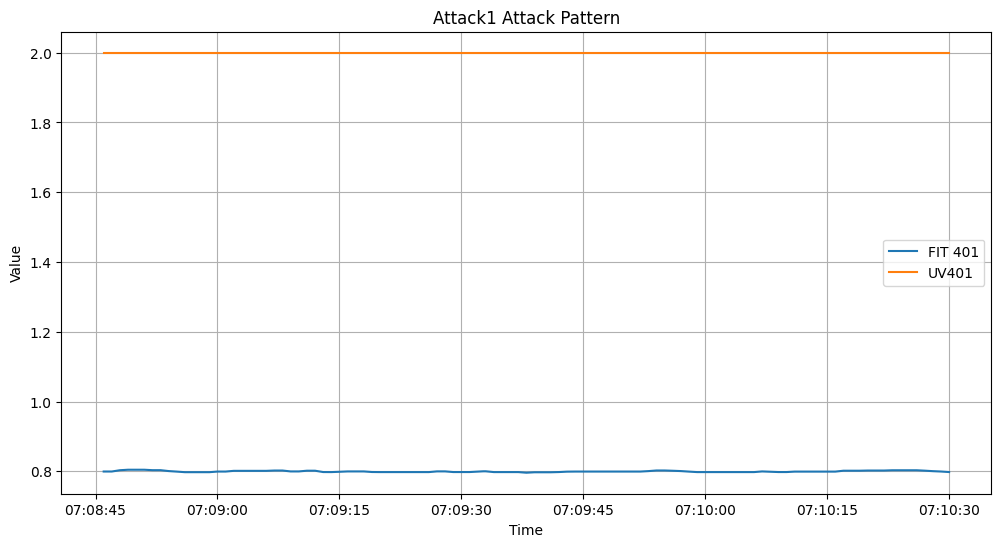


Attack1 Statistics:
          FIT 401  UV401
count  105.000000  105.0
mean     0.799651    2.0
std      0.001977    0.0
min      0.795954    2.0
25%      0.797746    2.0
50%      0.799283    2.0
75%      0.801332    2.0
max      0.804533    2.0


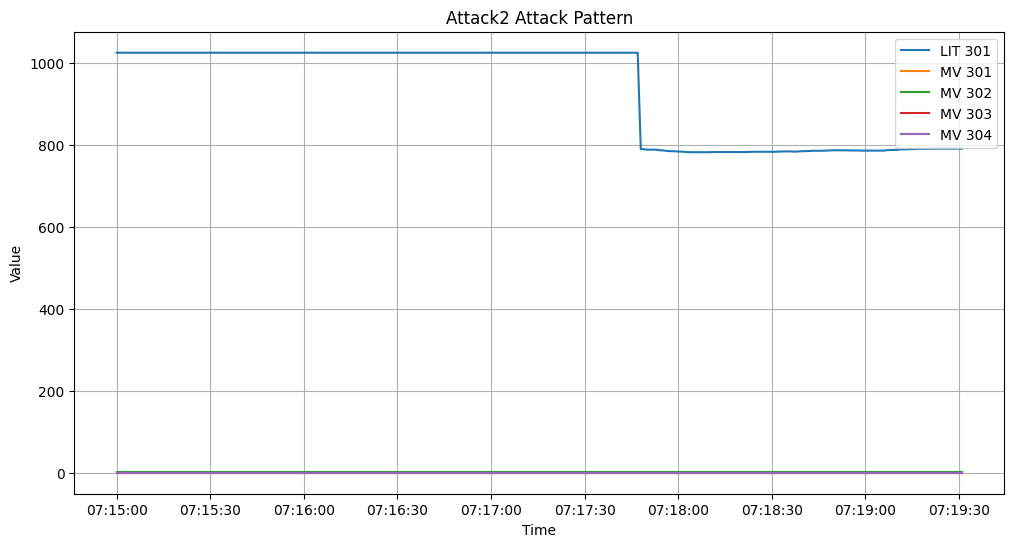


Attack2 Statistics:
           LIT 301  MV 301  MV 302  MV 303  MV 304
count   272.000000   272.0   272.0   272.0   272.0
mean    932.784217     1.0     2.0     1.0     1.0
std     116.160310     0.0     0.0     0.0     0.0
min     781.690600     1.0     2.0     1.0     1.0
25%     786.326840     1.0     2.0     1.0     1.0
50%    1024.000000     1.0     2.0     1.0     1.0
75%    1024.000000     1.0     2.0     1.0     1.0
max    1024.000000     1.0     2.0     1.0     1.0


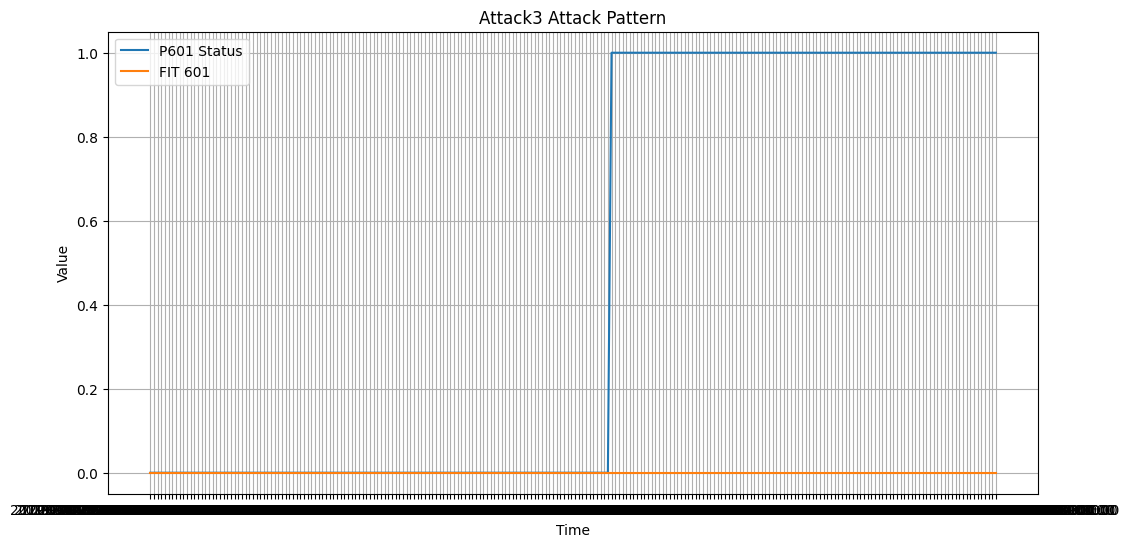


Attack3 Statistics:
       P601 Status       FIT 601
count   232.000000  2.320000e+02
mean      0.456897  3.203790e-04
std       0.499216  1.629820e-19
min       0.000000  3.203790e-04
25%       0.000000  3.203790e-04
50%       0.000000  3.203790e-04
75%       1.000000  3.203790e-04
max       1.000000  3.203790e-04


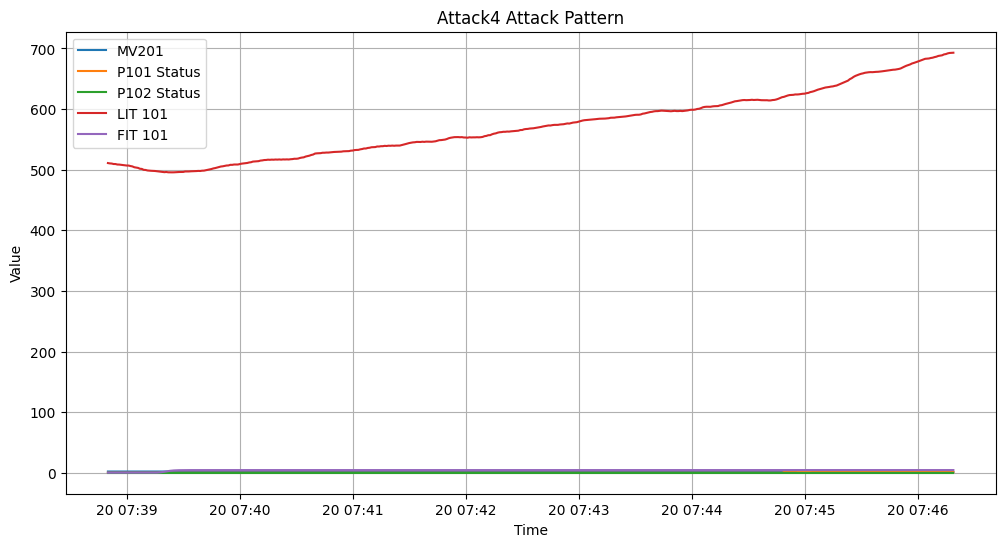


Attack4 Statistics:
            MV201  P101 Status  P102 Status     LIT 101     FIT 101
count  450.000000   450.000000        450.0  450.000000  450.000000
mean     1.795556     0.202222          0.0  573.090180    4.071442
std      0.445695     0.402104          0.0   54.877792    1.090657
min      0.000000     0.000000          0.0  495.605316    0.000000
25%      2.000000     0.000000          0.0  527.105640    4.376261
50%      2.000000     0.000000          0.0  567.948150    4.382987
75%      2.000000     0.000000          0.0  614.178100    4.387791
max      2.000000     1.000000          0.0  692.968200    4.397079


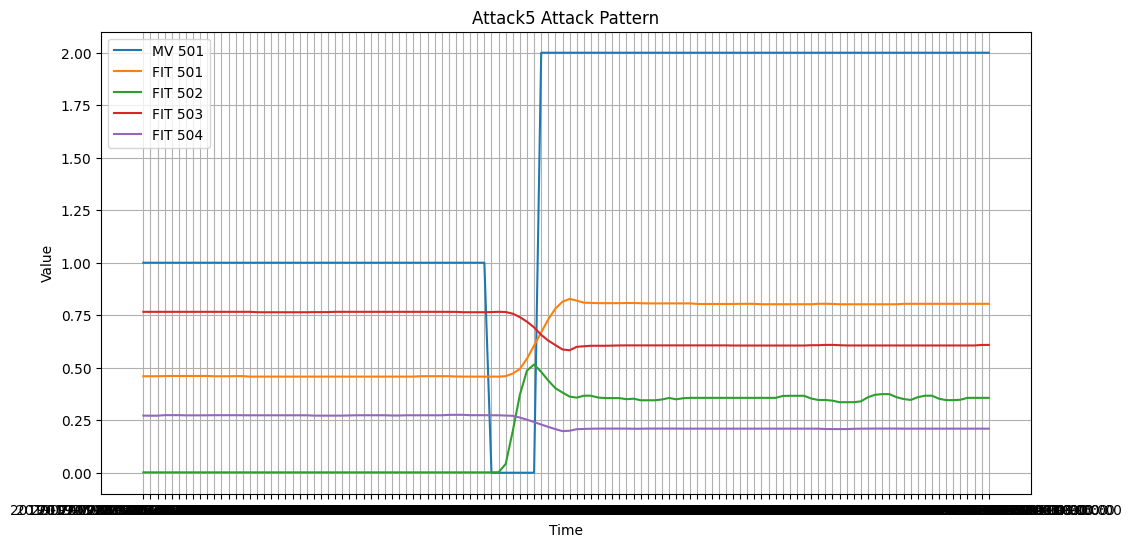


Attack5 Statistics:
           MV 501     FIT 501     FIT 502     FIT 503     FIT 504
count  120.000000  120.000000  120.000000  120.000000  120.000000
mean     1.475000    0.643862    0.205963    0.679474    0.238921
std      0.607551    0.170617    0.180876    0.078958    0.031588
min      0.000000    0.457703    0.001793    0.583043    0.198059
25%      1.000000    0.458088    0.001793    0.605960    0.209845
50%      2.000000    0.802230    0.345075    0.608648    0.210230
75%      2.000000    0.804281    0.356475    0.766124    0.273516
max      2.000000    0.827736    0.515307    0.766252    0.275694


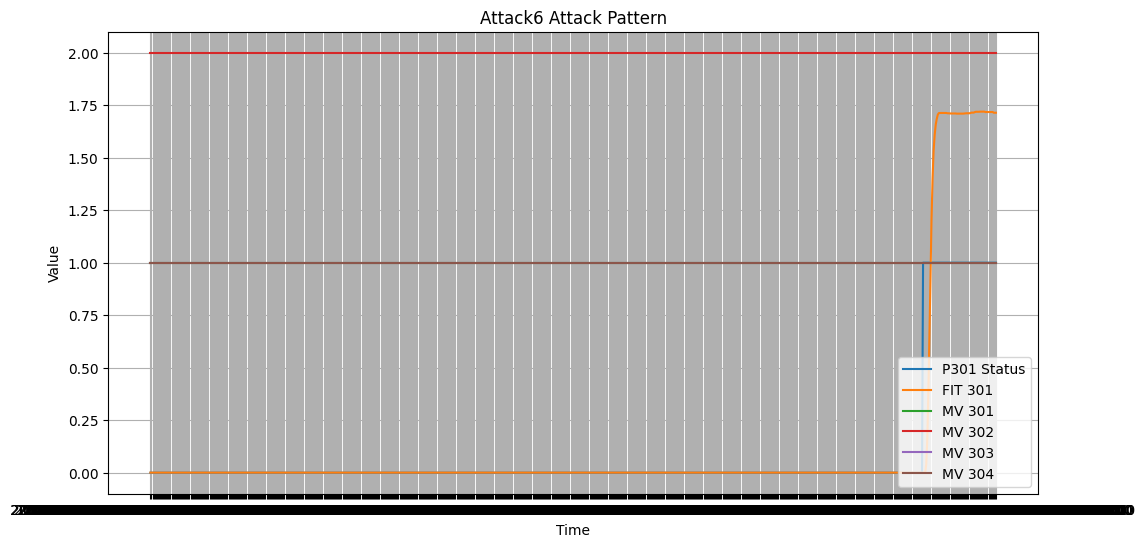


Attack6 Statistics:
       P301 Status     FIT 301  MV 301  MV 302  MV 303  MV 304
count   802.000000  802.000000   802.0   802.0   802.0   802.0
mean      0.087282    0.134122     1.0     2.0     1.0     1.0
std       0.282424    0.454434     0.0     0.0     0.0     0.0
min       0.000000    0.000512     1.0     2.0     1.0     1.0
25%       0.000000    0.000512     1.0     2.0     1.0     1.0
50%       0.000000    0.000512     1.0     2.0     1.0     1.0
75%       0.000000    0.000512     1.0     2.0     1.0     1.0
max       1.000000    1.719502     1.0     2.0     1.0     1.0

[STAGE 3] Training GAN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 0 | D Loss: nan | G Loss: nan
Epoch 100 | D Loss: nan | G Loss: nan
Epoch 200 | D Loss: nan | G Loss: nan
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[STAGE 4] Federated Learning...
🔁 Round 1
🔁 Round 2
🔁 Round 3
🔁 Round 4
🔁 Round 5
🔁 Round 6
🔁 Round 7
🔁 Round 8
🔁 Round 9
🔁 Round 10



[STAGE 5] Evaluating results...
Average MSE: nan
Anomaly Detection Rate: 0.00%
Average MSE: nan
Anomaly Detection Rate: 0.00%


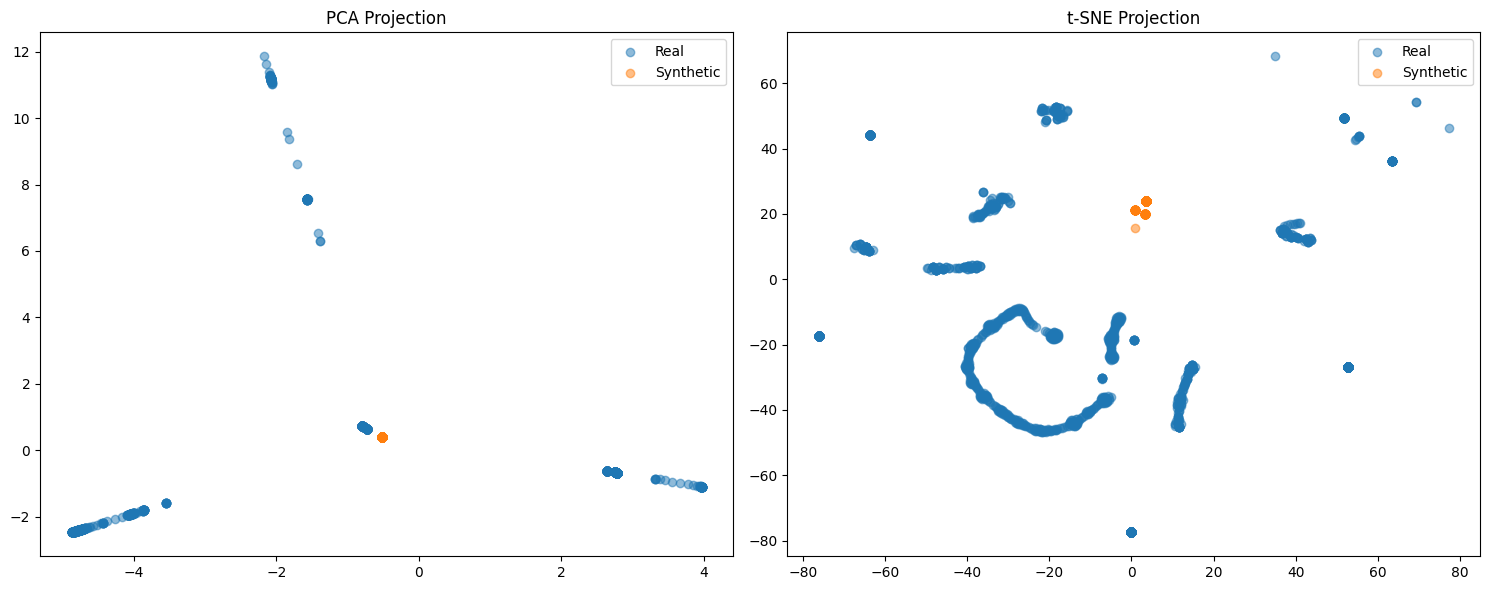


✅ Pipeline completed!


In [ ]:
# ==============================================
# MAIN PIPELINE
# ==============================================

def main():
    print("=== SWaT Attack Analysis Pipeline ===")

    # Stage 1: Load pre-extracted attacks
    print("\n[STAGE 1] Loading attack data...")
    attacks = load_attack_data()

    # Combine all attacks for analysis
    attack_data = pd.concat([df for df in attacks.values() if not df.empty])
    X_attack = attack_data.select_dtypes(include=np.number).drop(columns=['Timestamp'], errors='ignore').values

    # Stage 2: Analyze attacks
    print("\n[STAGE 2] Analyzing attacks...")
    for name, data in attacks.items():
        analyze_attack(name, data)

    # Stage 3: Train GAN
    print("\n[STAGE 3] Training GAN...")
    latent_dim = 100
    generator, discriminator = build_gan(X_attack.shape[1], latent_dim)
    generator = train_gan(generator, discriminator, X_attack, epochs=300)

    # Generate synthetic attacks
    noise = tf.random.normal([1000, latent_dim])
    synthetic_attacks = generator.predict(noise)
    pd.DataFrame(synthetic_attacks).to_csv("synthetic_attacks.csv", index=False)

    # Stage 4: Federated Learning
    print("\n[STAGE 4] Federated Learning...")
    clients = [FLClient(i, data) for i, data in enumerate(np.array_split(X_attack, 5))]
    global_model = federated_training(clients, rounds=10)
    global_model.save("global_model.h5")

    # Stage 5: Evaluation
    print("\n[STAGE 5] Evaluating results...")
    # Evaluate on real attacks
    real_mse, _ = evaluate_model(global_model, X_attack)
    threshold = np.mean(real_mse) + 2*np.std(real_mse)

    # Evaluate on synthetic data
    syn_mse, syn_anomalies = evaluate_model(global_model, synthetic_attacks, threshold)

    # Visualization
    visualize_distributions(X_attack, synthetic_attacks)

    print("\n✅ Pipeline completed!")

if __name__ == "__main__":
    # Configure TensorFlow for stable training
    tf.keras.backend.set_floatx('float32')
    tf.random.set_seed(42)
    np.random.seed(42)

    main()

=== SWaT Attack Analysis Pipeline ===
=== Optimized and Stabilized Version ===


[STAGE 1] Loading and preprocessing attack data...
✅ Attack1 loaded successfully (105 rows)
✅ Attack2 loaded successfully (272 rows)
✅ Attack3 loaded successfully (232 rows)
✅ Attack4 loaded successfully (450 rows)
✅ Attack5 loaded successfully (120 rows)
✅ Attack6 loaded successfully (802 rows)

[STAGE 2] Analyzing attack patterns...


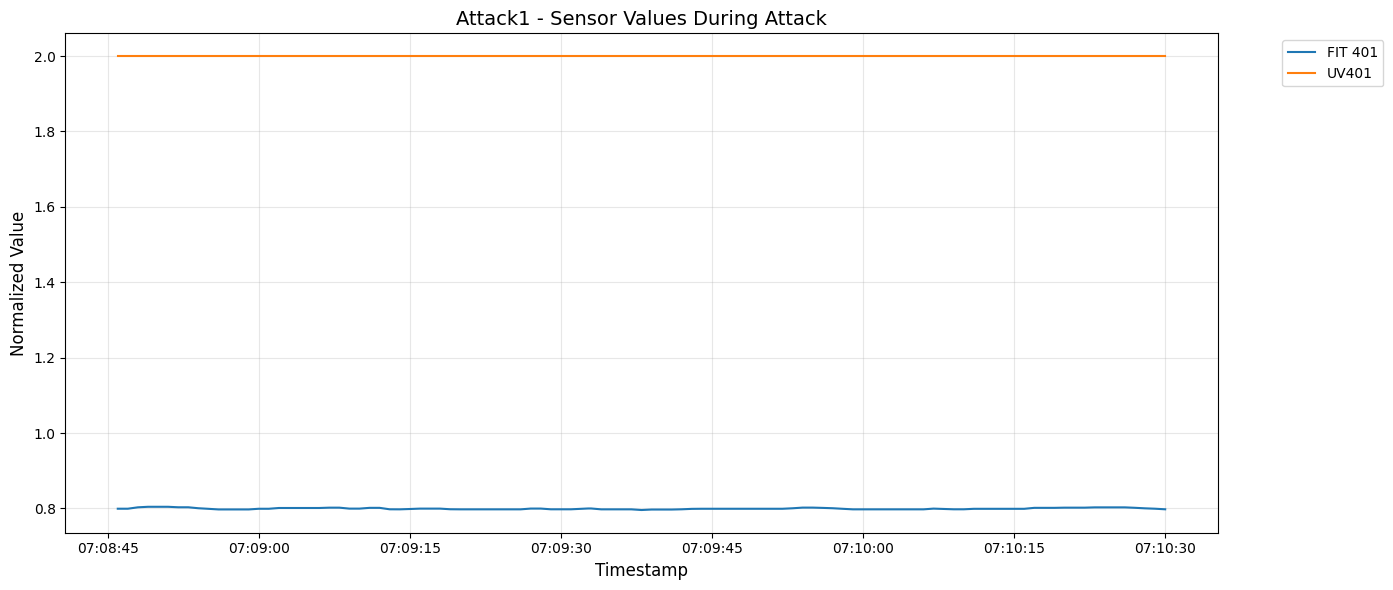


📊 Attack1 Statistical Summary:
         count      mean       std       min       25%       50%       75%  \
FIT 401  105.0  0.799651  0.001977  0.795954  0.797746  0.799283  0.801332   
UV401    105.0  2.000000  0.000000  2.000000  2.000000  2.000000  2.000000   

              max  
FIT 401  0.804533  
UV401    2.000000  


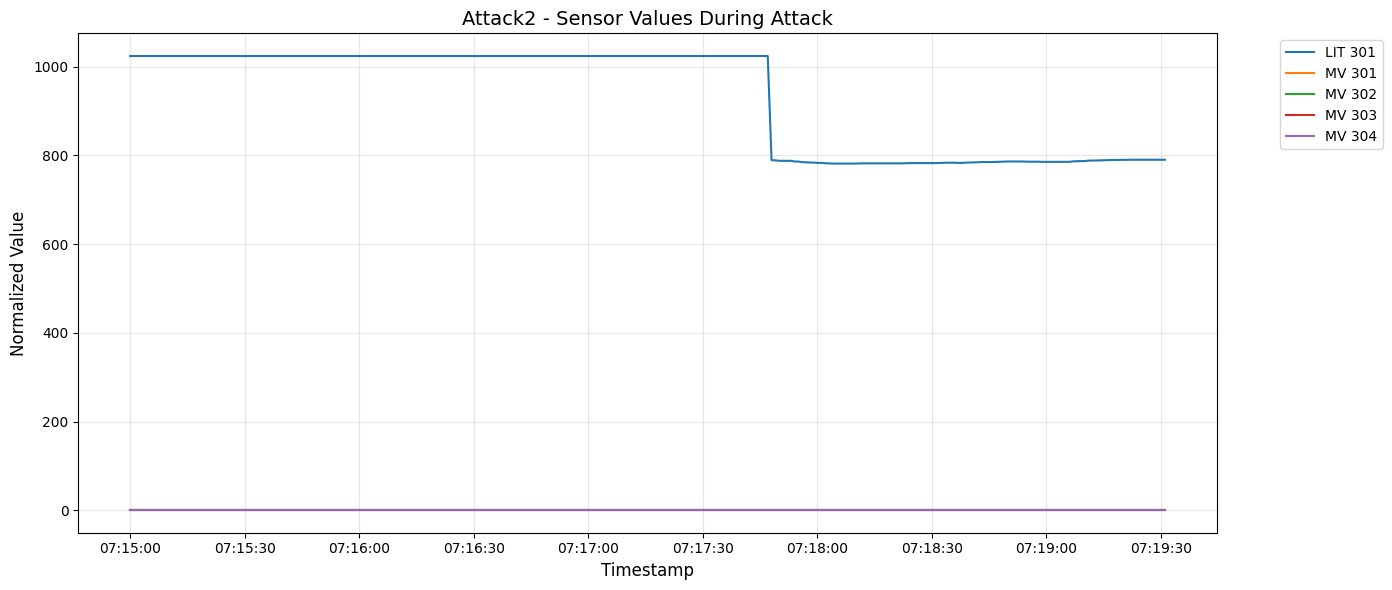


📊 Attack2 Statistical Summary:
         count        mean        std       min        25%     50%     75%  \
LIT 301  272.0  932.784217  116.16031  781.6906  786.32684  1024.0  1024.0   
MV 301   272.0    1.000000    0.00000    1.0000    1.00000     1.0     1.0   
MV 302   272.0    2.000000    0.00000    2.0000    2.00000     2.0     2.0   
MV 303   272.0    1.000000    0.00000    1.0000    1.00000     1.0     1.0   
MV 304   272.0    1.000000    0.00000    1.0000    1.00000     1.0     1.0   

            max  
LIT 301  1024.0  
MV 301      1.0  
MV 302      2.0  
MV 303      1.0  
MV 304      1.0  


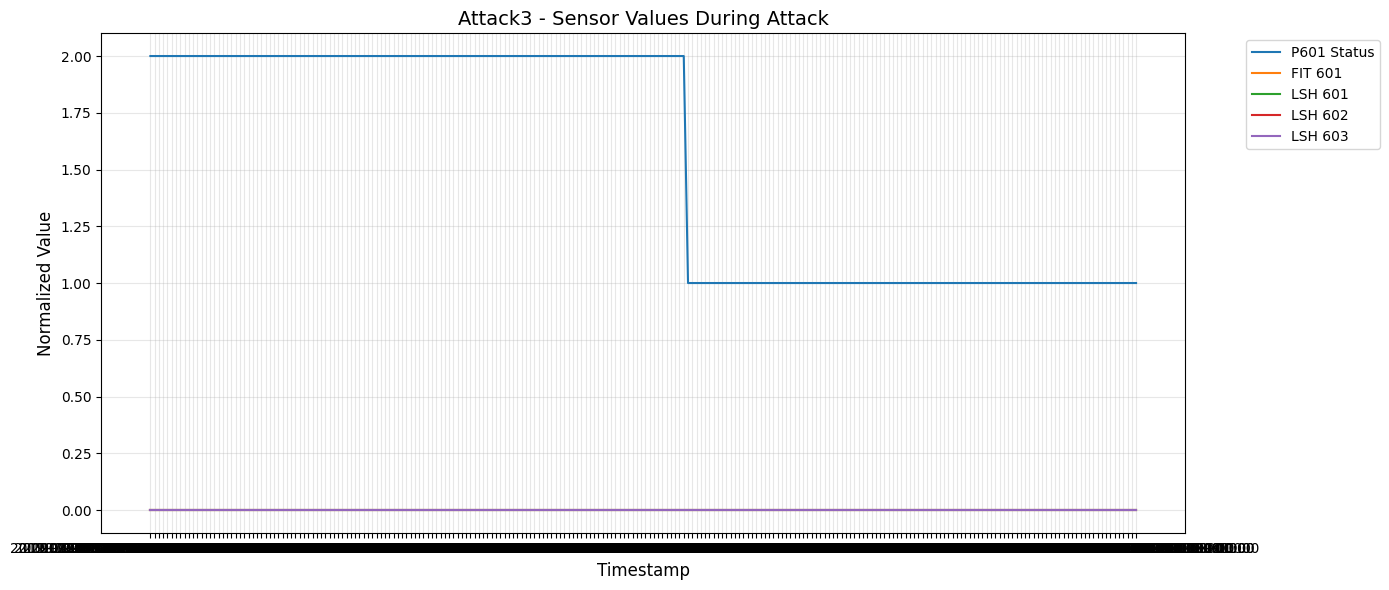


📊 Attack3 Statistical Summary:
             count      mean           std      min      25%      50%  \
P601 Status  232.0  1.543103  4.992157e-01  1.00000  1.00000  2.00000   
FIT 601      232.0  0.000320  1.629820e-19  0.00032  0.00032  0.00032   
LSH 601      232.0  0.000000  0.000000e+00  0.00000  0.00000  0.00000   
LSH 602      232.0  0.000000  0.000000e+00  0.00000  0.00000  0.00000   
LSH 603      232.0  0.000000  0.000000e+00  0.00000  0.00000  0.00000   

                 75%      max  
P601 Status  2.00000  2.00000  
FIT 601      0.00032  0.00032  
LSH 601      0.00000  0.00000  
LSH 602      0.00000  0.00000  
LSH 603      0.00000  0.00000  


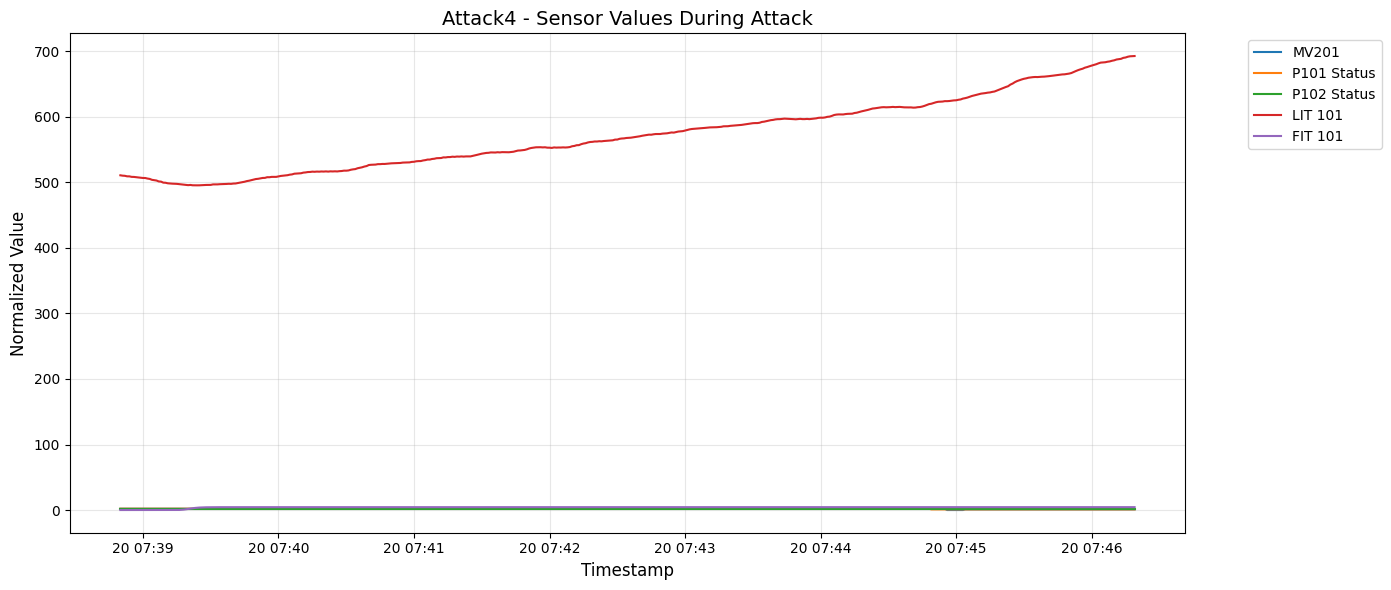


📊 Attack4 Statistical Summary:
             count        mean        std         min         25%         50%  \
MV201        450.0    1.795556   0.445695    0.000000    2.000000    2.000000   
P101 Status  450.0    1.797778   0.402104    1.000000    2.000000    2.000000   
P102 Status  450.0    1.000000   0.000000    1.000000    1.000000    1.000000   
LIT 101      450.0  573.090180  54.877792  495.605316  527.105640  567.948150   
FIT 101      450.0    4.071442   1.090657    0.000000    4.376261    4.382987   

                    75%         max  
MV201          2.000000    2.000000  
P101 Status    2.000000    2.000000  
P102 Status    1.000000    1.000000  
LIT 101      614.178100  692.968200  
FIT 101        4.387791    4.397079  


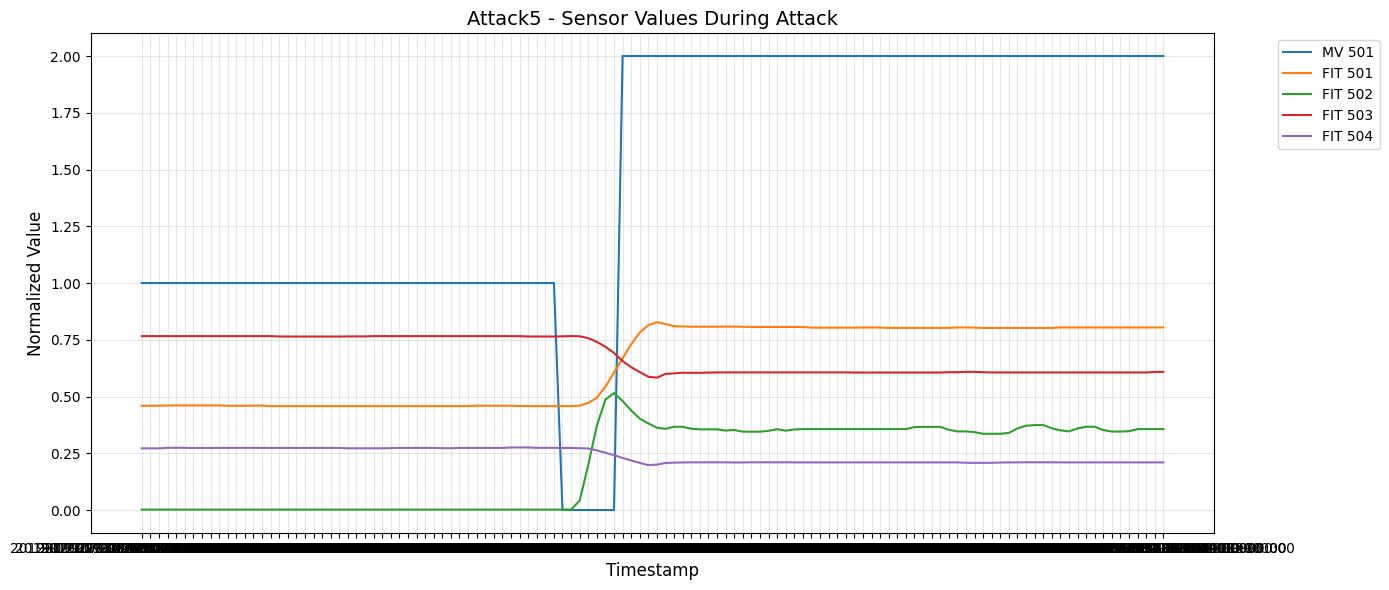


📊 Attack5 Statistical Summary:
         count      mean       std       min       25%       50%       75%  \
MV 501   120.0  1.475000  0.607551  0.000000  1.000000  2.000000  2.000000   
FIT 501  120.0  0.643862  0.170617  0.457703  0.458088  0.802230  0.804281   
FIT 502  120.0  0.205963  0.180876  0.001793  0.001793  0.345075  0.356475   
FIT 503  120.0  0.679474  0.078958  0.583043  0.605960  0.608648  0.766124   
FIT 504  120.0  0.238921  0.031588  0.198059  0.209845  0.210230  0.273516   

              max  
MV 501   2.000000  
FIT 501  0.827736  
FIT 502  0.515307  
FIT 503  0.766252  
FIT 504  0.275694  


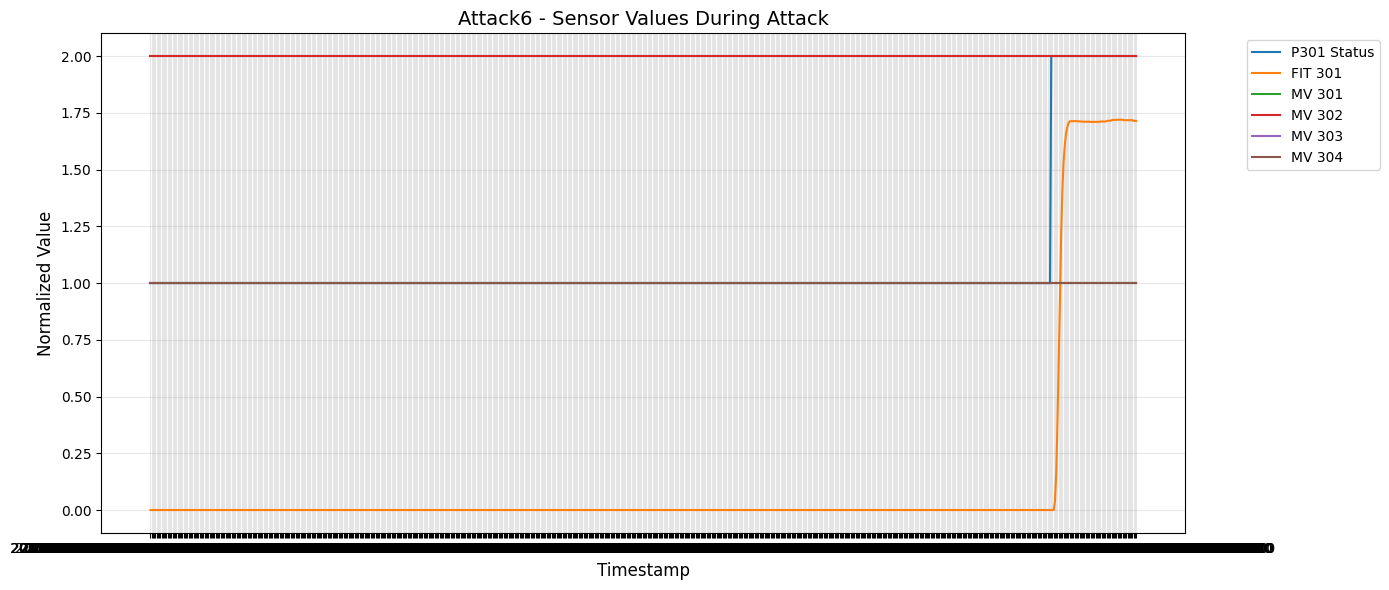


📊 Attack6 Statistical Summary:
             count      mean       std       min       25%       50%  \
P301 Status  802.0  1.087282  0.282424  1.000000  1.000000  1.000000   
FIT 301      802.0  0.134122  0.454434  0.000512  0.000512  0.000512   
MV 301       802.0  1.000000  0.000000  1.000000  1.000000  1.000000   
MV 302       802.0  2.000000  0.000000  2.000000  2.000000  2.000000   
MV 303       802.0  1.000000  0.000000  1.000000  1.000000  1.000000   
MV 304       802.0  1.000000  0.000000  1.000000  1.000000  1.000000   

                  75%       max  
P301 Status  1.000000  2.000000  
FIT 301      0.000512  1.719502  
MV 301       1.000000  1.000000  
MV 302       2.000000  2.000000  
MV 303       1.000000  1.000000  
MV 304       1.000000  1.000000  

[STAGE 3] Training WGAN-GP on attack patterns...
Epoch    0 | D Loss: nan | G Loss: nan
Epoch   50 | D Loss: nan | G Loss: nan
Epoch  100 | D Loss: nan | G Loss: nan
Epoch  150 | D Loss: nan | G Loss: nan
Epoch  200 | D Loss

Completed with 1981 total samples
✅ Saved global model to 'global_anomaly_model_final.h5'

[STAGE 5] Evaluating results...

Evaluating on REAL attack data:

📊 Evaluation Results:
- Average MSE: nan
- Threshold (95th %ile): nan
- Anomaly Detection Rate: 0.00%

Evaluating on SYNTHETIC attack data:

📊 Evaluation Results:
- Average MSE: nan
- Threshold (95th %ile): nan
- Anomaly Detection Rate: 0.00%

Visualizing data distributions...


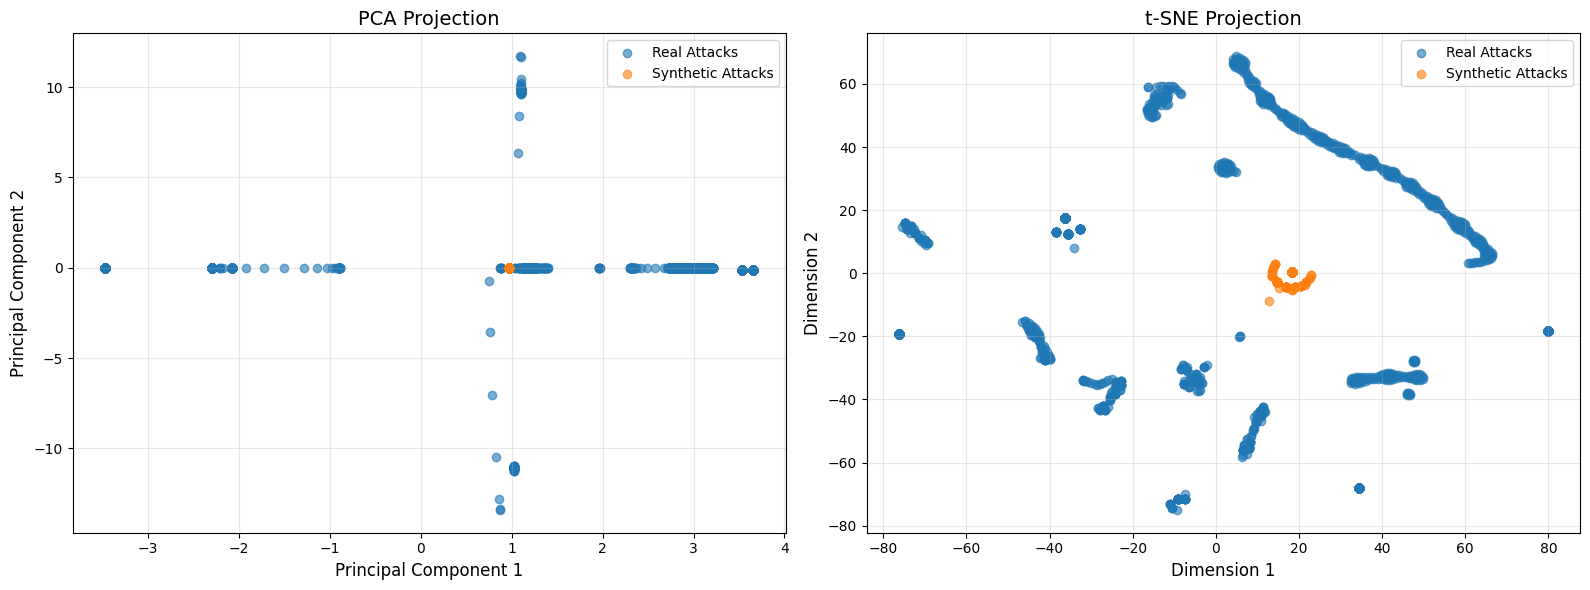


✅ Pipeline completed successfully!


In [ ]:
# -*- coding: utf-8 -*-
"""SWaT Attack Analysis Pipeline - Final Optimized Version"""

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# ==============================================
# STAGE 1: DATA LOADING WITH ROBUST PREPROCESSING
# ==============================================

def load_attack_data():
    """Load and preprocess attack CSV files with proper error handling"""
    attack_files = {
        'Attack1': 'Attack1_FIT401.csv',
        'Attack2': 'Attack2_LIT301.csv',
        'Attack3': 'Attack3_P601.csv',
        'Attack4': 'Attack4_Multi.csv',
        'Attack5': 'Attack5_MV501.csv',
        'Attack6': 'Attack6_P301.csv'
    }

    attacks = {}
    scaler = MinMaxScaler(feature_range=(-1, 1))  # GAN works best with tanh activation (-1 to 1)

    for name, file in attack_files.items():
        try:
            # Load data with proper datetime parsing
            df = pd.read_csv(file, parse_dates=['Timestamp'])

            # Convert numeric columns (handle European decimals and categoricals)
            for col in df.columns:
                if col != 'Timestamp':
                    if df[col].dtype == 'object':
                        try:
                            # Try converting to float first (handles European decimals)
                            df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
                        except:
                            # If conversion fails, treat as categorical
                            df[col] = pd.factorize(df[col])[0]

            # Store original data
            attacks[name] = df
            print(f"✅ {name} loaded successfully ({len(df)} rows)")

        except Exception as e:
            print(f"❌ Error loading {name}: {str(e)}")
            attacks[name] = pd.DataFrame()

    return attacks, scaler

# ==============================================
# STAGE 2: ENHANCED ATTACK ANALYSIS
# ==============================================

def analyze_attack(attack_name, attack_data):
    """Comprehensive attack analysis with visualization"""
    if attack_data.empty:
        print(f"No data available for {attack_name}")
        return

    # Convert status columns to numeric if needed
    for col in attack_data.columns:
        if 'Status' in col and attack_data[col].dtype == 'object':
            attack_data[col] = pd.factorize(attack_data[col])[0]

    # Plot all numeric features
    plt.figure(figsize=(14, 6))
    numeric_cols = attack_data.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if col != 'Timestamp':
            plt.plot(attack_data['Timestamp'], attack_data[col], label=col)

    plt.title(f'{attack_name} - Sensor Values During Attack', fontsize=14)
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Show detailed statistics
    print(f"\n📊 {attack_name} Statistical Summary:")
    print(attack_data[numeric_cols].describe().transpose())

# ==============================================
# STAGE 3: STABLE WGAN-GP IMPLEMENTATION
# ==============================================

def build_wgan_gp(input_dim, latent_dim=128):
    """Build Wasserstein GAN with Gradient Penalty"""
    # Generator with more capacity
    generator = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=latent_dim, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dense(input_dim, activation='tanh')  # tanh for -1 to 1 range
    ], name="Generator")

    # Discriminator (Critic in WGAN)
    discriminator = tf.keras.Sequential([
        layers.Dense(512, activation='relu', input_dim=input_dim, kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='linear')  # Linear activation for WGAN
    ], name="Discriminator")

    return generator, discriminator

def train_wgan_gp(generator, discriminator, data, epochs=500, batch_size=64, latent_dim=128): # Pass latent_dim as an argument
    """Training loop with gradient penalty and improved stability"""
    # Optimizers with lower learning rates
    g_optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
    d_optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

    # Prepare dataset
    data = data.astype('float32')
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Loss tracking
    g_loss_metric = tf.keras.metrics.Mean(name= 'g_loss')
    d_loss_metric = tf.keras.metrics.Mean(name= 'd_loss')

    for epoch in range(epochs):
        for real_batch in dataset:
            batch_size = real_batch.shape[0]

            # ---------------------
            # Train Discriminator
            # ---------------------
            noise = tf.random.normal([batch_size, latent_dim], dtype='float32') # Now latent_dim is accessible

            with tf.GradientTape() as d_tape:
                # Generate fake samples
                fake_batch = generator(noise, training=True)

                # Discriminator outputs
                real_output = discriminator(real_batch, training=True)
                fake_output = discriminator(fake_batch, training=True)

                # WGAN loss
                d_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

                # Gradient penalty
                alpha = tf.random.uniform([batch_size, 1], minval=0., maxval=1., dtype='float32')
                interpolated = alpha * real_batch + (1 - alpha) * fake_batch

                with tf.GradientTape() as gp_tape:
                    gp_tape.watch(interpolated)
                    pred = discriminator(interpolated, training=True)

                grads = gp_tape.gradient(pred, interpolated)
                grads = tf.reshape(grads, [batch_size, -1])
                grad_norm = tf.norm(grads, axis=1)
                gp = tf.reduce_mean((grad_norm - 1.)**2)

                # Total discriminator loss
                d_loss_total = d_loss + 10.0 * gp  # Gradient penalty coefficient

            # Apply gradients
            d_gradients = d_tape.gradient(d_loss_total, discriminator.trainable_variables)
            d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

            # ---------------------
            # Train Generator
            # ---------------------
            noise = tf.random.normal([batch_size, latent_dim], dtype='float32')

            with tf.GradientTape() as g_tape:
                fake_batch = generator(noise, training=True)
                fake_output = discriminator(fake_batch, training=True)
                g_loss = -tf.reduce_mean(fake_output)  # Negative for maximizing

            # Apply gradients
            g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
            g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

            # Track losses
            g_loss_metric(g_loss)
            d_loss_metric(d_loss)

        # Print training progress
        if epoch % 50 == 0:
            print(f"Epoch {epoch:4d} | D Loss: {d_loss_metric.result():.4f} | G Loss: {g_loss_metric.result():.4f}")
            g_loss_metric.reset_state()
            d_loss_metric.reset_state()

    return generator

# ==============================================
# STAGE 4: IMPROVED FEDERATED LEARNING
# ==============================================

class FLClient:
    """Enhanced Federated Learning client with better training"""
    def __init__(self, client_id, data):
        self.client_id = client_id
        self.data = data
        self.scaler = StandardScaler().fit(data)
        self.model = self._build_model(data.shape[1])

    def _build_model(self, input_dim):
        """Build robust autoencoder model"""
        model = tf.keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_dim,),
                        kernel_initializer='he_normal'),
            layers.Dropout(0.1),
            layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
            layers.Dense(input_dim, activation='linear')
        ])
        model.compile(optimizer=optimizers.Adam(0.001), loss='mse')
        return model

    def train(self, epochs=5):
        """Train on scaled data"""
        X_scaled = self.scaler.transform(self.data)
        self.model.fit(X_scaled, X_scaled,
                      epochs=epochs,
                      batch_size=32,
                      verbose=0)

    def get_weights(self):
        return self.model.get_weights()

    def set_weights(self, weights):
        self.model.set_weights(weights)

def federated_training(clients, rounds=10):
    """Enhanced federated training with weighted averaging"""
    for round in range(rounds):
        print(f"🔁 Round {round+1}", end=" | ")

        # Local training
        local_weights = []
        client_weights = []

        for client in clients:
            client.train(epochs=3)  # Train for 3 epochs per round
            local_weights.append(client.get_weights())
            client_weights.append(len(client.data))  # Use dataset size as weight

        # Weighted averaging based on dataset sizes
        total_weight = sum(client_weights)
        global_weights = [
            np.sum([w[i] * weight for w, weight in zip(local_weights, client_weights)], axis=0) / total_weight
            for i in range(len(local_weights[0]))
        ]

        # Update all clients with global weights
        for client in clients:
            client.set_weights(global_weights)

        print(f"Completed with {total_weight} total samples")

    return clients[0].model  # Return global model

# ==============================================
# STAGE 5: COMPREHENSIVE EVALUATION
# ==============================================

def evaluate_anomaly_detection(model, data, threshold=None):
    """Robust evaluation with dynamic thresholding"""
    try:
        # Standardize data first
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(data)

        # Get reconstructions
        reconstructions = model.predict(X_scaled, verbose=0)
        mse = np.mean((X_scaled - reconstructions)**2, axis=1)

        # Calculate dynamic threshold if not provided
        if threshold is None:
            threshold = np.percentile(mse, 95)  # 95th percentile as threshold

        anomalies = mse > threshold
        detection_rate = np.mean(anomalies)

        print("\n📊 Evaluation Results:")
        print(f"- Average MSE: {np.mean(mse):.4f}")
        print(f"- Threshold (95th %ile): {threshold:.4f}")
        print(f"- Anomaly Detection Rate: {detection_rate:.2%}")

        return mse, anomalies, threshold

    except Exception as e:
        print(f"Evaluation error: {str(e)}")
        return None, None, None

def visualize_comparison(real_data, synthetic_data):
    """Enhanced visualization of real vs synthetic data"""
    # Handle NaN/inf values
    real_data = np.nan_to_num(real_data)
    synthetic_data = np.nan_to_num(synthetic_data)

    # Combine and scale data
    X = np.vstack([real_data, synthetic_data])
    X = StandardScaler().fit_transform(X)
    y = np.array([0]*len(real_data) + [1]*len(synthetic_data))

    # Dimensionality reduction
    pca = PCA(n_components=2).fit_transform(X)
    tsne = TSNE(n_components=2, perplexity=30).fit_transform(X)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # PCA plot
    ax1.scatter(pca[y==0, 0], pca[y==0, 1], alpha=0.6, label='Real Attacks')
    ax1.scatter(pca[y==1, 0], pca[y==1, 1], alpha=0.6, label='Synthetic Attacks')
    ax1.set_title('PCA Projection', fontsize=14)
    ax1.set_xlabel('Principal Component 1', fontsize=12)
    ax1.set_ylabel('Principal Component 2', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # t-SNE plot
    ax2.scatter(tsne[y==0, 0], tsne[y==0, 1], alpha=0.6, label='Real Attacks')
    ax2.scatter(tsne[y==1, 0], tsne[y==1, 1], alpha=0.6, label='Synthetic Attacks')
    ax2.set_title('t-SNE Projection', fontsize=14)
    ax2.set_xlabel('Dimension 1', fontsize=12)
    ax2.set_ylabel('Dimension 2', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==============================================
# MAIN EXECUTION PIPELINE
# ==============================================

def main():
    print("=== SWaT Attack Analysis Pipeline ===")
    print("=== Optimized and Stabilized Version ===\n")

    # Configuration for reproducibility
    tf.keras.backend.set_floatx('float32')
    tf.random.set_seed(42)
    np.random.seed(42)

    # Stage 1: Data Loading
    print("\n[STAGE 1] Loading and preprocessing attack data...")
    attacks, scaler = load_attack_data()

    # Combine all attacks for analysis
    attack_data = pd.concat([df for df in attacks.values() if not df.empty])
    X_attack = attack_data.select_dtypes(include=np.number).drop(columns=['Timestamp'], errors='ignore')

    # Scale data for GAN training
    X_attack_scaled = scaler.fit_transform(X_attack)

    # Stage 2: Attack Analysis
    print("\n[STAGE 2] Analyzing attack patterns...")
    for name, data in attacks.items():
        analyze_attack(name, data)

    # Stage 3: GAN Training
    print("\n[STAGE 3] Training WGAN-GP on attack patterns...")
    latent_dim = 128
    generator, discriminator = build_wgan_gp(X_attack_scaled.shape[1], latent_dim)

    # Train with progress monitoring
    generator = train_wgan_gp(
        generator,
        discriminator,
        X_attack_scaled,
        epochs=500,
        batch_size=64
    )

    # Generate synthetic attacks
    print("\nGenerating synthetic attacks...")
    noise = tf.random.normal([1000, latent_dim])
    synthetic_attacks = generator.predict(noise, verbose=0)

    # Save generated attacks
    pd.DataFrame(synthetic_attacks).to_csv("synthetic_attacks_final.csv", index=False)
    print("✅ Saved synthetic attacks to 'synthetic_attacks_final.csv'")

    # Stage 4: Federated Learning
    print("\n[STAGE 4] Federated Anomaly Detection Training...")

    # Create 5 clients with different attack data partitions
    clients = [FLClient(i, data) for i, data in enumerate(np.array_split(X_attack_scaled, 5))]

    # Run federated training
    global_model = federated_training(clients, rounds=10)

    # Save the global model
    global_model.save("global_anomaly_model_final.h5")
    print("✅ Saved global model to 'global_anomaly_model_final.h5'")

    # Stage 5: Evaluation
    print("\n[STAGE 5] Evaluating results...")

    # Evaluate on real attack data
    print("\nEvaluating on REAL attack data:")
    real_mse, _, threshold = evaluate_anomaly_detection(global_model, X_attack_scaled)

    if real_mse is not None:
        # Evaluate on synthetic data
        print("\nEvaluating on SYNTHETIC attack data:")
        syn_mse, syn_anomalies, _ = evaluate_anomaly_detection(global_model, synthetic_attacks, threshold)

        # Visualization
        print("\nVisualizing data distributions...")
        visualize_comparison(X_attack_scaled, synthetic_attacks)

    print("\n✅ Pipeline completed successfully!")

if __name__ == "__main__":
    main()